# Вебинар 4. Обучение с учителем.

**Обучение с учителем** = есть целевая переменная (таргет), которую мы предсказываем

_Регрессия_ - таргет непрерывен
- Предсказание цен на дома
- Предсказание спроса на товары
- ...


_Классификация_ - Таргет принимает 2 (иногда k) значений
- Кредитный скоринг: вернет кредит (target=0) или нет (target=1)
- Определение вида животного по фото (0 - лев, 1 - пантера, 2 - леопард, ... , k - гепард) 
- ...

**Обучение без учителя** = нет целевой переменной:
- Разделение данных на группы
- ...



---

**ЭТАПЫ Data Science проекта:**
1. Определить бизнес проблему
2. Убедить бизнес, что ее можно и нужно решать с помощью ML =)
3. Перевести бизнес проблему в ML-задачу
4. Выбрать подходящие ML и бизнес метрики
---------------------------------------------------------------------------
5. Загрузка данных (все вебинары + курс по SQL)
6. EDA: визуализация данных (вебинар 3)
7. Очистка данных и feature engineering (вебинар 2)
8. **_Разбиение данных на train и test_**
9. **_Построение ML моделей*_**
10. **_Оценка качества ML моделей и выбор наилучшей_**

---------------------------------------------------------------------------
11. Доказать бизнес-заказчику, что модель хорошо работает (отдельный курс: А/В тесты в курсе мат. статистики)
12. Внедрение модели в production (отдельный курс) 
13. Улучшение модели
14. Поддержка модели

In [1]:
!pip install numpy

(!) Будет отдельный курс по Алгоритмам, где вам подробно расскажут про ML модели 

---

**Подключение библиотек и скриптов**

In [36]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# !conda install -c conda-forge lightgbm
from lightgbm import LGBMRegressor


# 4. Метирки качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [37]:
import warnings

warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [38]:
PREPARED_DATASET_PATH = '/Users/physboy/Downloads/Webinar_4 2/housing_prepared.csv'

REPORTS_FILE_PATH = '/Users/physboy/Downloads/Webinar_4 2/'
MODEL_FILE_PATH = '/Users/physboy/Downloads/Webinar_4 2/' 

# Шаг 1. Загрузка данных

По **reduce_mem_usage** смотри вебинар 3

In [39]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

In [40]:
df = pd.read_csv(PREPARED_DATASET_PATH)
df = reduce_mem_usage(df)
df.head()

Memory usage of dataframe is 1.95 MB
Memory usage after optimization is: 0.75 MB
Decreased by 61.5%


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,1,0,452600.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,1,0,358500.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,1,0,352100.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,1,0,341300.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,1,0,342200.0


In [41]:
df.dtypes

longitude             float32
latitude              float32
housing_median_age    float32
total_rooms           float32
total_bedrooms        float32
population            float32
households            float32
median_income         float32
<1H OCEAN                int8
INLAND                   int8
NEAR BAY                 int8
NEAR OCEAN               int8
median_house_value    float32
dtype: object

# Шаг 2. EDA и очистка данных

*В этом вебинаре мы не будем остаанавливаться на EDA, но в проекте это сделать нужно - __смотри вебинар 3__

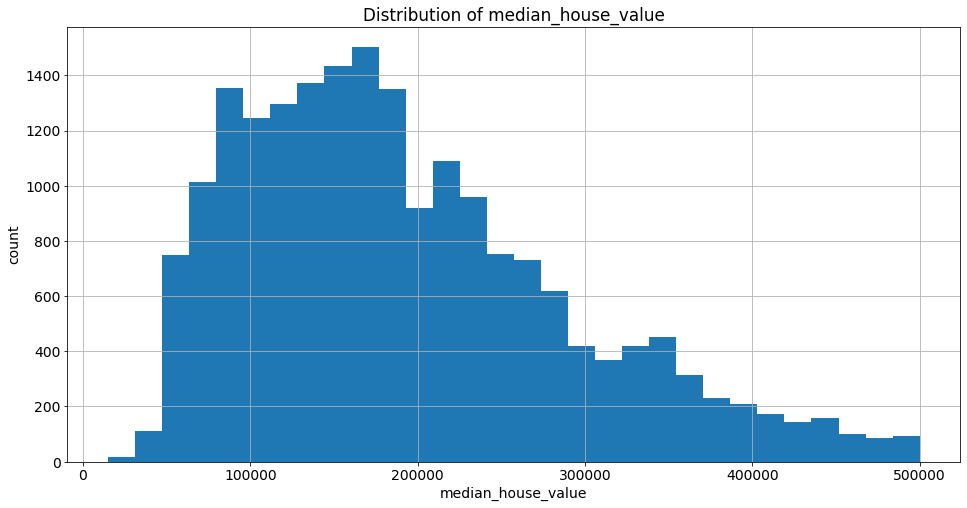

In [42]:
plt.figure(figsize = (16, 8))

df['median_house_value'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('median_house_value')

plt.title('Distribution of median_house_value')
plt.show()

In [43]:
df = df[df['median_house_value'] <= 500000].reset_index()

# Шаг 3: Очистка данных и Feature engineering

*Пример вы можете посметреть в вебинаре 2: __class DataPipeline__

In [44]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        # <your code>
        
    def fit(self, df):
        """Сохранение статистик"""
        # <your code>
        
    def transform(self, df):
        """Трансформация данных"""
        # <your code>

---

**Оставим признаки, которые необходимы для модели**

In [45]:
df.columns.tolist()

['index',
 'longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 '<1H OCEAN',
 'INLAND',
 'NEAR BAY',
 'NEAR OCEAN',
 'median_house_value']

In [46]:
feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
                 'households',
                 'median_income', '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN']

target_name = 'median_house_value'

In [47]:
df = df[feature_names + [target_name]]
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,1,0,452600.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,1,0,358500.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,1,0,352100.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,1,0,341300.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,1,0,342200.0


### Сохранение  датасета

In [48]:
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')

# Шаг 4. Разбиение на train / test

In [14]:
X = df[feature_names]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

# Шаг 5. Построение моделей

Бизнес метрика - **R^2**, Root Mean Squared Error (**RMSE**)
    - Бизнес метрика интерпретируема
    - Понятна бизнесу
    - Ее мы показываем бизнесу
    - RMSE - на сколько, в среднем, $ мы ошибаемся при предсказании цен 
    - R^2 принимает значения от 0 до 1, если 1 - все предсказания идеальны. Можно сказать, что это "точность" модели
    
ML метрика - Mean Squared Error (**MSE**) 
    - (!) MSE прямопропорциональна RMSE и R^2
    - MSE  удобно оптимизировать (брать производные)
    - MSE используется "под капотом" наших ML моделей


Лучшая модель - модель с наименьшей MSE на test 

 $$MSE = \frac{1}{n}  \sum{(y - y_{pred})^2}$$

$$RMSE = \sqrt{\frac{1}{n}  \sum{(y - y_{pred})^2}}$$

$$R^2 = 1 - \frac{\sum{(y - y_{pred})^2}}{\sum{(y - y_{mean})^2}}$$

In [49]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### 5.1 Linear Regression

$$price = a_0 + a_1 * households + a_2 * rooms$$

Подробное объяснение [здесь](https://towardsdatascience.com/linear-regression-understanding-the-theory-7e53ac2831b5)

R2:	0.612
RMSE:	60504.587
MSE:	3660805055.234


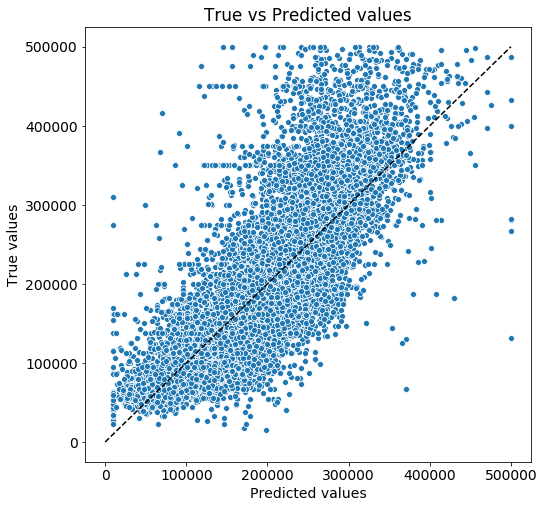

In [50]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
# Постпрецессинг
y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

R2:	0.609
RMSE:	61743.325
MSE:	3812238150.317


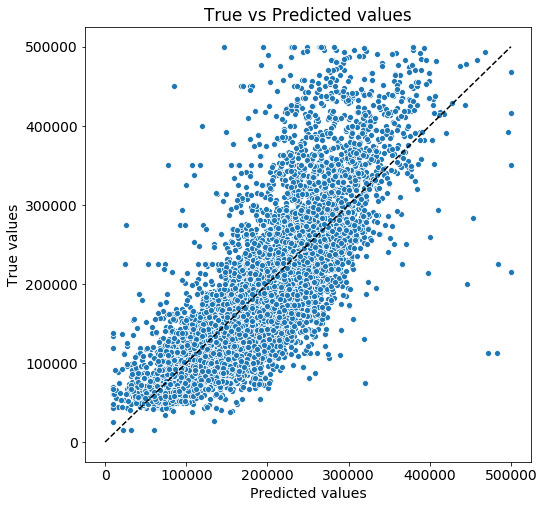

In [51]:
y_test_preds = lr_model.predict(X_test)

# Постпрецессинг
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500000)

evaluate_preds(y_test, y_test_preds)

### 5.2 Decision tree

Подробнее можно почитать [здесь](https://medium.com/@chiragsehra42/decision-trees-explained-easily-28f23241248ь)

На примере задачи: _Сколько времени человек потратит на онлайн игры?_  (0 - 24 часа/день)

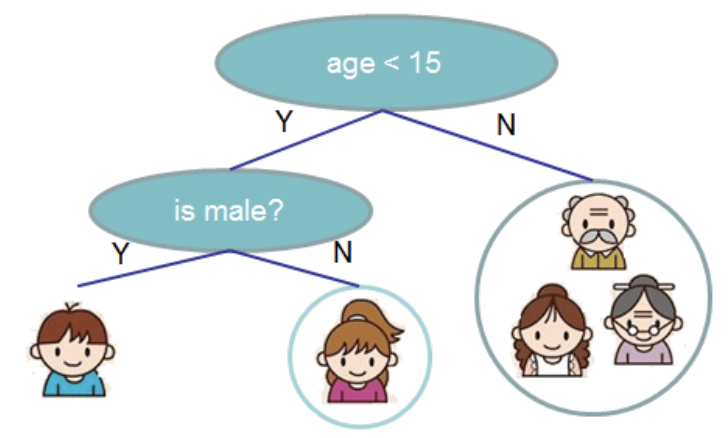

In [18]:
Image(filename='dt_explained.png', width=716, height=455)

- age < 15 and is_male > 0.5 ---> 5
- age < 15 and is_male <= 0.5 ---> 0
- age >= 15 ---> 1

Decision tree может моделировать зависимости такого вида:

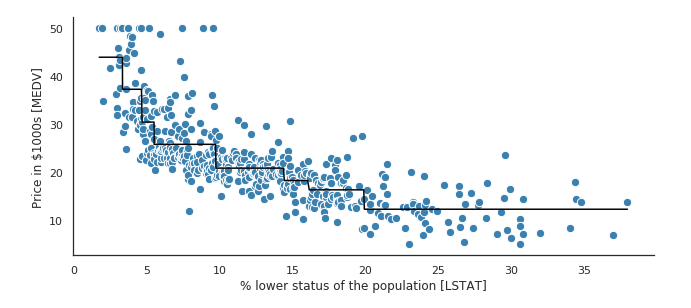

In [19]:
Image(filename='dt_example.png')

R2:	0.723
RMSE:	51123.741
MSE:	2613636927.577


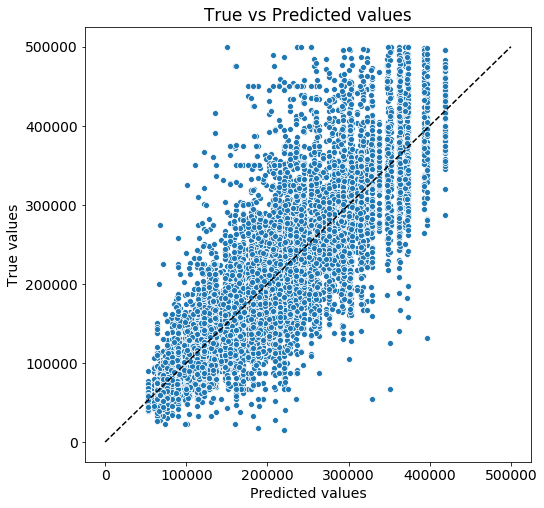

In [54]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=50, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42)
dt_model.fit(X_train, y_train)

y_train_preds = dt_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.683
RMSE:	55600.896
MSE:	3091459653.604


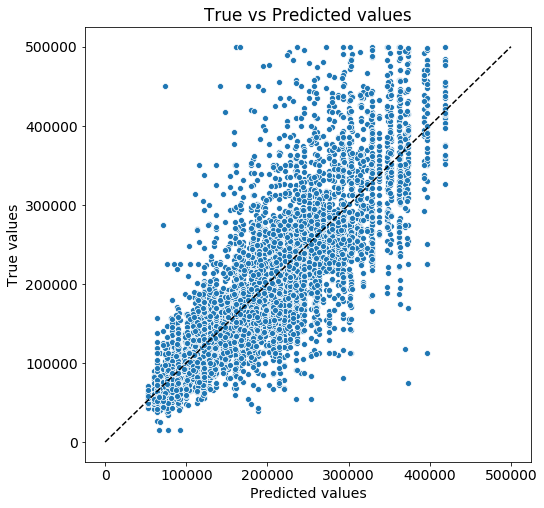

In [55]:
y_test_preds = dt_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### 5.3 Random Forest

Подробнее можно почитать [здесь](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)

**Независимо** строятся N дереьвев. Их **предсказания усредняются**

Чтобы деревья получались разными добавляют элемент случайности:
- каждое дерево строят на подвыборке данных (случайно сэмплируют 70% данных)
- каждое дерево строят на подвыборке фич (случайно сэмплируют 70% фич)
- ...

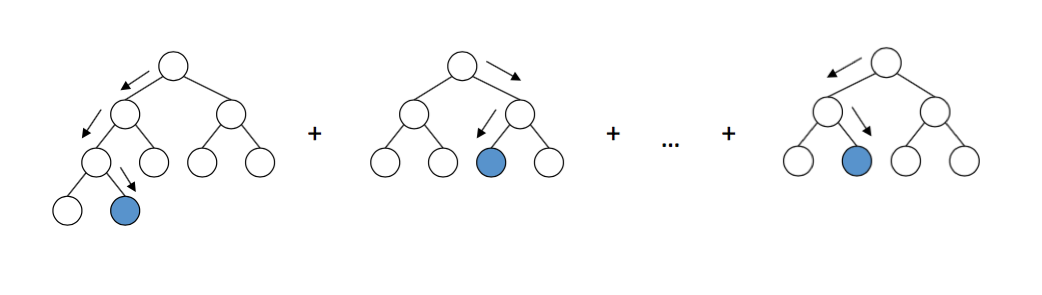

In [22]:
Image(filename='rf_explained.png')

R2:	0.765
RMSE:	47095.127
MSE:	2217951004.545


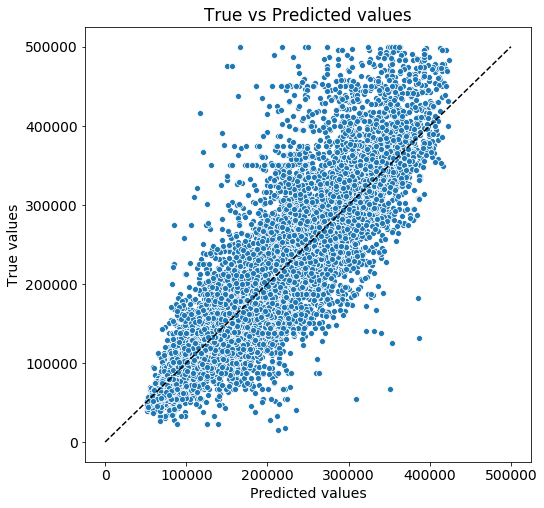

In [57]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                
                                n_estimators=100  # кол-во деревьев
                                )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.725
RMSE:	51767.66
MSE:	2679890668.157


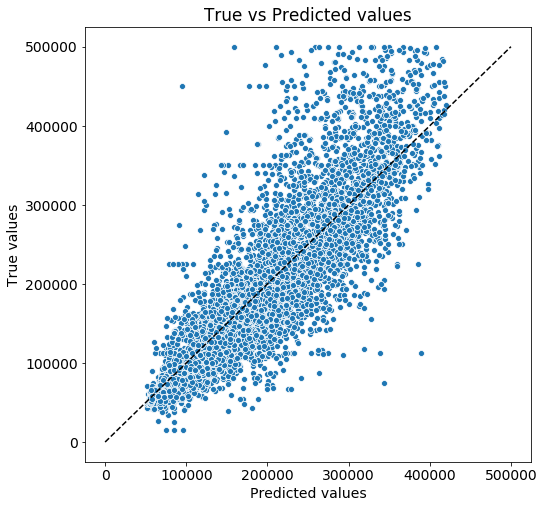

In [58]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### 5.4 (Light) Gradient Boosting decision trees

Подробнее можно почитать [здесь](https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d)

**Последовательно** строятся N деревьев: новое дерево обучается на ошибках предыдущих. **Предсказания деревьев суммируются**

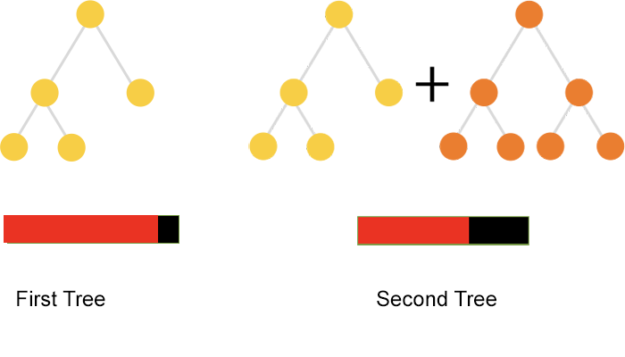

In [25]:
Image(filename='gb_explained.png')

In [26]:
y = np.array([10, 20, 30, 5, 10])

# Первое дерево
y_pred_1 = np.array([8, 25, 34, 10, 3])
error_1 = y - y_pred_1

error_1

array([ 2, -5, -4, -5,  7])

In [27]:
gb_pred = y_pred_1
r2(y, gb_pred)

0.7025

In [28]:
# Второе дерево: таргет = ошибки первого (error_1)
y_2 = error_1
y_pred_2 = np.array([1, -4, -2, -1, 3])

error_2 = y_2 - y_pred_2
error_2

array([ 1, -1, -2, -4,  4])

In [29]:
gb_pred = y_pred_1 + y_pred_2
r2(y, gb_pred)

0.905

In [30]:
### Второе дерево: таргет = ошибки gb (error_1)
y_3 = y - gb_pred

y_pred_3 = np.array([0, -1, -1, -1, 1])
error_2 = y_3 - y_pred_3
error_2

array([ 1,  0, -1, -3,  3])

In [31]:
gb_pred = y_pred_1 + y_pred_2 + y_pred_3
r2(y, gb_pred)

0.95

---

R2:	0.848
RMSE:	37844.9
MSE:	1432236418.23


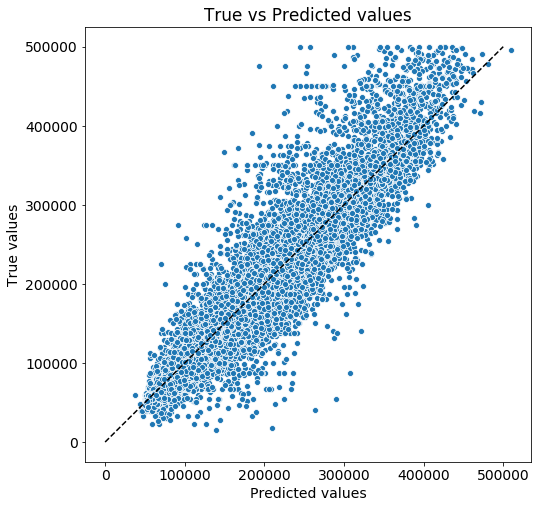

In [59]:
lgb_model = LGBMRegressor(criterion='mse',
                        max_depth=7, # Неглубокие < 10
                        min_samples_leaf=10,
                        random_state=42,  
                        
                        n_estimators=100)

lgb_model.fit(X_train, y_train)

y_train_preds = lgb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.797
RMSE:	44479.763
MSE:	1978449328.484


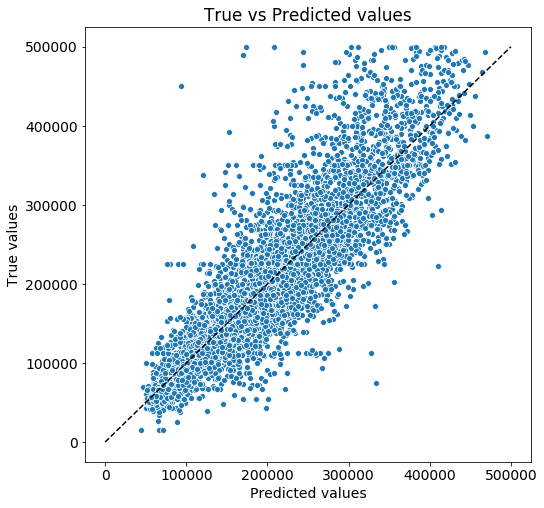

In [61]:
y_test_preds = lgb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

# Шаг 6.** Настройка и оценка финальной модели

!!!  кросс-валидация проходит на трейне, test не трогаем  !!!

[Кросс валидация](https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85) и подбор гиперпараметров

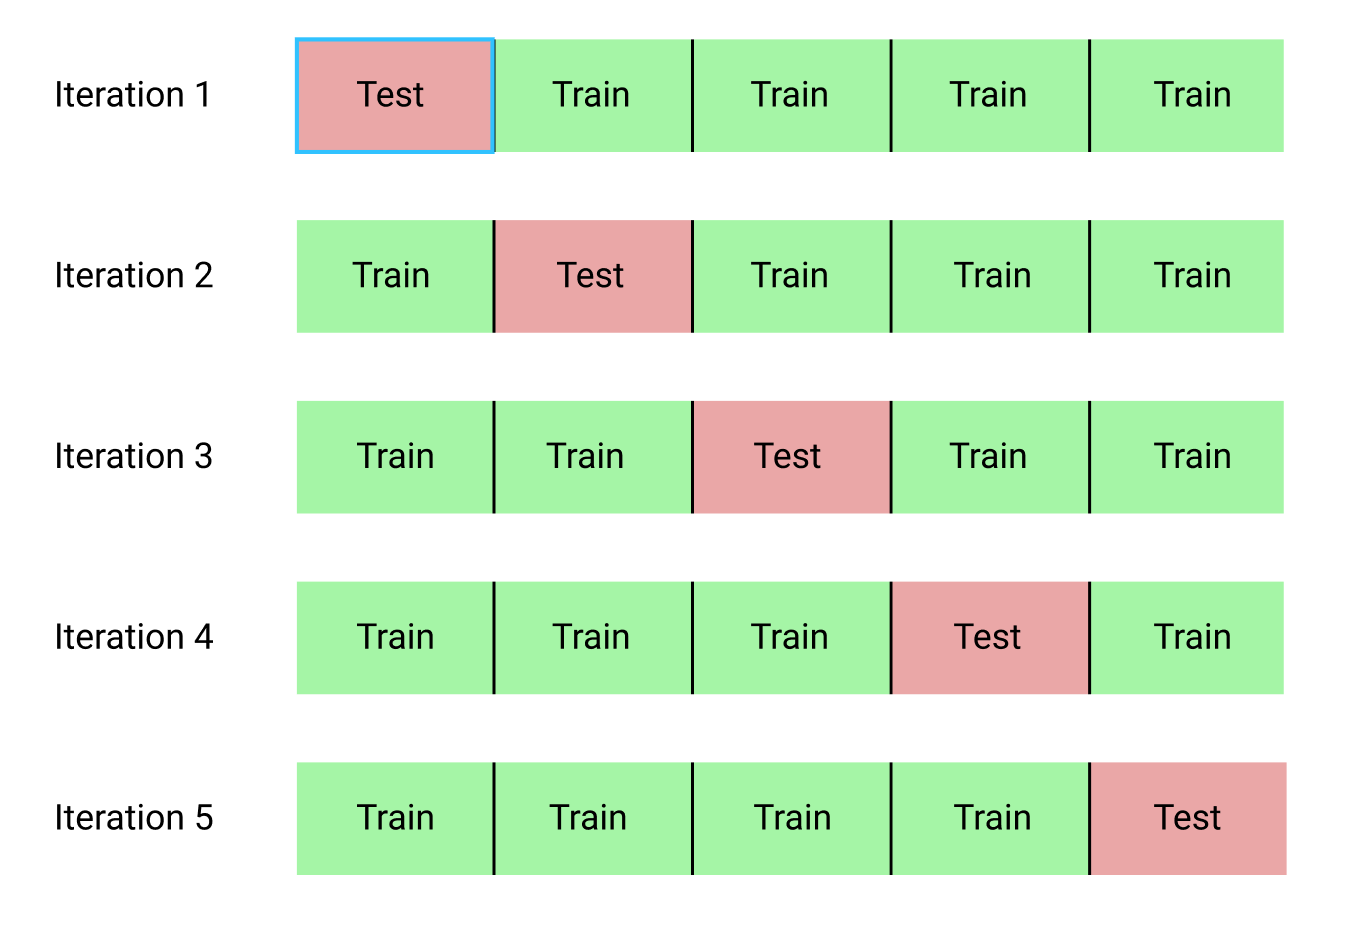

In [34]:
Image(filename='kfold.png', height=500, width=500)

In [63]:
X_train.shape

(13182, 12)

In [35]:
# Одну модель (одни и те же гиперпараметры)

# Iteration_1
X_train__test_1 = X_train.iloc[:2500, :]
y_train__test_1 = y_train.iloc[:2500, :]

X_train__train_1 = X_train.iloc[2500:, :]
y_train__train_1 = y_train.iloc[2500:, :]


# обучаем модель на X_train__train_1, y_train__train_1
# предсказываем на X_train__test_1, y_train__test_1
# R2__1 = r2(y_pred__test_1, y_train__test_1) = 0.83


# Iteration_2
X_train__test_2 = X_train.iloc[2500:5000, :]
y_train__test_2 = y_train.iloc[2500:5000, :]

X_train__train_2 = X_train.drop(np.arange(2500, 5000), inplace=True)
y_train__train_2 = y_train.drop(np.arange(2500, 5000), inplace=True)


# обучаем модель на X_train__train_2, y_train__train_2
# предсказываем на X_train__test_2, y_train__test_2
# R2__2 = r2(y_pred__test_2, y_train__test_2) = 0.87


# ...

# R2 = [0.83, 0.87, 0.79, 0.8, 0.91]

IndexingError: Too many indexers

In [98]:
R2 = np.array([0.83, 0.87, 0.79, 0.8, 0.91])
np.mean(R2)

0.8400000000000001

In [99]:
# Сделали то же самое для модели с другими гиперпараметрами

In [100]:
# cross val R2 model_1 = 0.84
# cross val R2 model_2 = 0.87 - выбираем эту модель (ее гиперпараметры)

In [101]:
# ЗАНОВО Обучаем модель с наилучшими гиперпараметрами (те, которые дают максимальный cross val R2) на ВСЕМ train

---

In [133]:
lgb_model = LGBMRegressor(criterion='mse',
                            min_samples_leaf=10,
                            random_state=42 #,
                         
                         # n_estimators=100,
                         # max_depth=7
                         
                         )

In [65]:
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(lgb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                 )
gs.fit(X_train, y_train)  # НА TRAIN!

GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0, criterion='mse',
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=7, min_child_samples=20,
                                     min_child_weight=0.001,
                                     min_samples_leaf=10, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10

In [66]:
res = pd.DataFrame(gs.cv_results_)
res.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.100157,0.004492,0.019042,0.001005,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.679452,0.688187,0.665918,0.664505,0.676623,0.674937,0.008820,16
1,0.164423,0.003312,0.019979,0.003319,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.732963,0.739682,0.720266,0.728630,0.733669,0.731042,0.006437,15
2,0.239073,0.017074,0.030191,0.002002,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.768243,0.771307,0.759931,0.764147,0.770817,0.766889,0.004306,12
3,0.389287,0.010952,0.051587,0.002148,3,400,"{'max_depth': 3, 'n_estimators': 400}",0.788501,0.787301,0.783283,0.782835,0.789451,0.786274,0.002716,9
4,0.137366,0.006985,0.013711,0.000439,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.749593,0.752105,0.734476,0.737118,0.753195,0.745298,0.007889,14


In [67]:
gs.best_params_

{'max_depth': 10, 'n_estimators': 400}

In [68]:
gs.best_score_

0.8048247958974383

**Обучение и оценка модели**

R2:	0.927
RMSE:	26274.848
MSE:	690367611.505


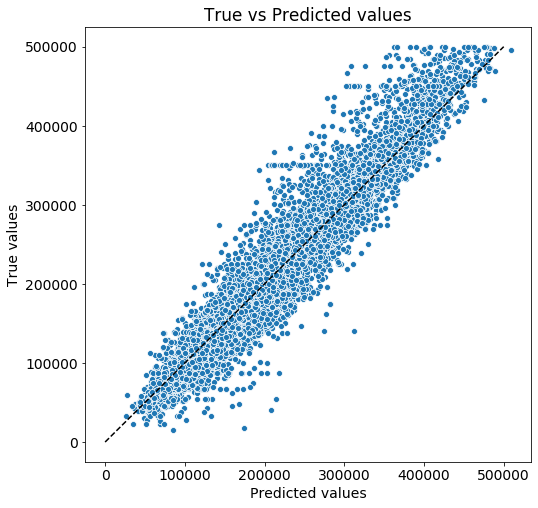

In [73]:
final_model = LGBMRegressor(criterion='mse',
                            max_depth=10,
                            min_samples_leaf=10,
                            random_state=42,  

                            n_estimators=400)

final_model.fit(X_train, y_train)

y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.814
RMSE:	42559.767
MSE:	1811333772.469


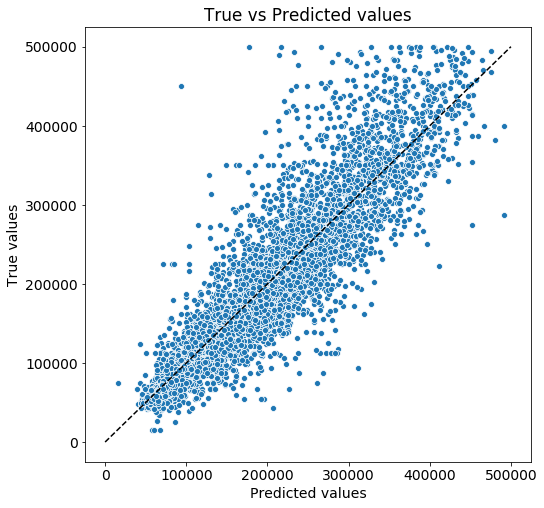

In [74]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds,save=True)

# Шаг 7.* Анализ прогнозов

**Важность признаков**

In [75]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_ / final_model.feature_importances_.sum()), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

**Топ-3 фичи**

In [76]:
feature_importances.head(3)

,feature_name,importance
0,longitude,0.168307
1,latitude,0.168057
7,median_income,0.145038


**Худшие 3 фичи**

In [78]:
feature_importances.tail(3)

,feature_name,importance
8,<1H OCEAN,0.009341
11,NEAR OCEAN,0.008340
10,NEAR BAY,0.002252


In [79]:
feature_importances.to_csv(REPORTS_FILE_PATH + 'feature_importances.csv', index=False)

# Шаг 8. Сохранение модели

In [145]:
with open(MODEL_FILE_PATH + 'fianl_mpdel.pkl', 'wb') as file:
    pickle.dump(final_model, file)

In [146]:
with open(MODEL_FILE_PATH + 'fianl_mpdel.pkl', 'rb') as file:
    my_model = pickle.load(file)
    
my_model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              criterion='mse', importance_type='split', learning_rate=0.1,
              max_depth=10, min_child_samples=20, min_child_weight=0.001,
              min_samples_leaf=10, min_split_gain=0.0, n_estimators=400,
              n_jobs=-1, num_leaves=31, objective=None, random_state=42,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

----

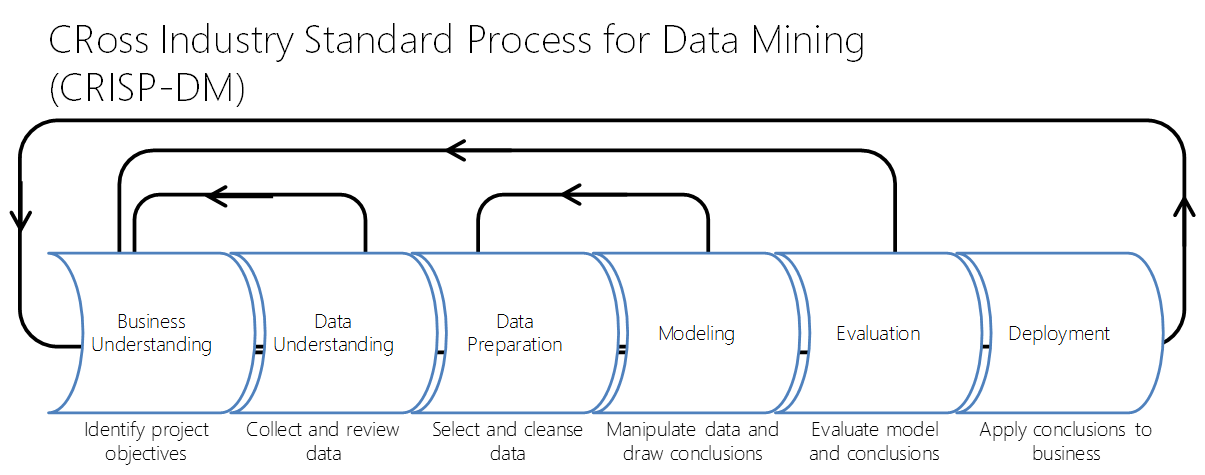

In [134]:
Image(filename='ds_pipeline.png')